# Model 1

This uses Logistic Regression to tell whether to expect high or low call volume based on weather. 
But since the vast majority of call volume is Heat/Hot Water releated, it is kind of overwhelming in that way. So we're just going to use only the Heat/Hot Water calls.

It turns out that weather can be used to predict high volume calls using a logistic model. 


In [1]:
import pandas as pd
import numpy as np

import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#df_joined = pd.read_csv("~/Projects/CourseraCapstone/joined.csv")

In [52]:
df_incidents = pd.read_csv("csvs/top_ten_311.csv", dtype={5: 'str', 6:'str'}) 
#df_incidents.drop(axis=1, columns=['Unique Key'], inplace=True)
df_incidents.set_index('Date Only', inplace=True)
df_ten = (df_incidents[df_incidents['Complaint Type'] == 'HEAT/HOT WATER'])#.groupby(['Date Only'])

df_weather = pd.read_csv("csvs//Weather_One_Shot.csv", index_col=0)
df_weather['Date Only'] = df_weather['DATE'].apply(lambda x: x[0:10])
df_weather.set_index('Date Only', inplace=True)
df_weather.drop(axis=1, columns=['DATE','Sunrise','Sunset'], inplace=True)

#df_joined = df_weather.join(df_incidents)
#df.columns

RangeIndex(start=0, stop=1, step=1)

In [53]:
#pd.DataFrame(df_incidents.groupby(['Date Only', 'Complaint Type']).count()).to_csv('csvs/grouped_top_ten.csv')
df_ten.columns

Index(['Unique Key', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor',
       'Incident Zip'],
      dtype='object')

In [204]:
df_ten = pd.read_csv("csvs/grouped_top_ten.csv", index_col = 0, usecols=[0,1,2], dtype={0:'str',1:'str',2:'int'})
df_ten = df_ten[df_ten['Complaint Type'] == 'HEAT/HOT WATER']
df_ten = df_weather.join(df_ten, how="inner", on="Date Only")
df_ten.rename(index=str, columns={"Unique Key": "Count"}, inplace=True)
df_ten['t2'] = df_ten[[ 'DailyAverageDryBulbTemperature']].pow(2)
#df_joined.head(10)
#df_ten.head()

In [205]:
#df_joined.std()

In [206]:
#df_joined.skew()

In [207]:
#df_joined.kurtosis()

In [208]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#print(confusion_matrix(y_test, yhat, labels=[1,0]))

In [209]:
#df_weather.head()

In [211]:
#X = np.asarray(df_weather[['Condition_Blizzard', 'Condition_Normal', 'Condition_Rain', 'Condition_TStorm', 'Condition_Wind', 'Temperature_VCold', 'Temperature_Chilly', 'Temperature_Warm']])
X = np.asarray(df_ten[[ 'DailyAverageDryBulbTemperature','t2']])
#'Condition_Normal', 'Condition_Rain', 'Condition_Snow', 'Condition_Snowpack', 'Condition_Wind', 'Temperature_Cold', 'Temperature_Freezing', 'Temperature_Hot', 'Temperature_Warm']])
X.shape


(1599, 2)

In [212]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/Users/dtt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dtt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.28, -1.2 ],
       [-0.95, -0.98],
       [-1.  , -1.02],
       [-0.38, -0.53],
       [-1.17, -1.13]])

In [220]:
cutoff = 400

y_ = df_ten.Count.apply(lambda x: 1 if (x > cutoff) else 0)
y = np.asarray(y_)


In [221]:

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

y_train = np.nan_to_num(y_train)
df = pd.DataFrame(y_train)
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

Train set: (1279, 2) (1279,)
Test set: (320, 2) (320,)


,0


In [222]:

LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

jaccard_similarity_score(y_test, yhat)


0.959375

Confusion matrix, without normalization
[[157   5]
 [  8 150]]


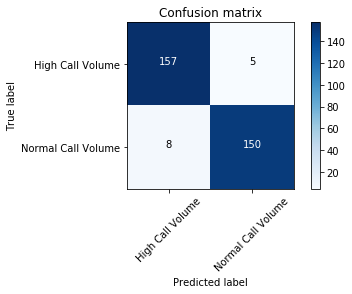

In [223]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['High Call Volume','Normal Call Volume'],normalize= False,  title='Confusion matrix')



In [217]:
df_ten.DailyAverageDryBulbTemperature[df_ten.Count < cutoff].min()

53

In [218]:
df_ten.DailyAverageDryBulbTemperature[df_ten.Count > cutoff].max()

72

In [219]:
df_ten.Count.mean()

630.8774233896185